This notebook contains my first approach, which turned out to be not so good. Briefly, after detecting horizontal and vertical lines with the Hough algorithm, these are clustered into groups that define a single line of the grid. The parameters of such lines are derived from the cluster, then the intersections are used to find the 3x3 boxes of the sodoku. Finding the right boxes is quite hard, hence I abandoned this method.

In [1]:
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
import keras
import os

Using TensorFlow backend.


In [2]:
def show_images(images, plotter=None):
    plotter = plotter or (lambda x: plt.imshow(x, cmap='gray'))
    
    plt.figure(figsize=(20, 10))
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plotter(images[i])
    plt.show()

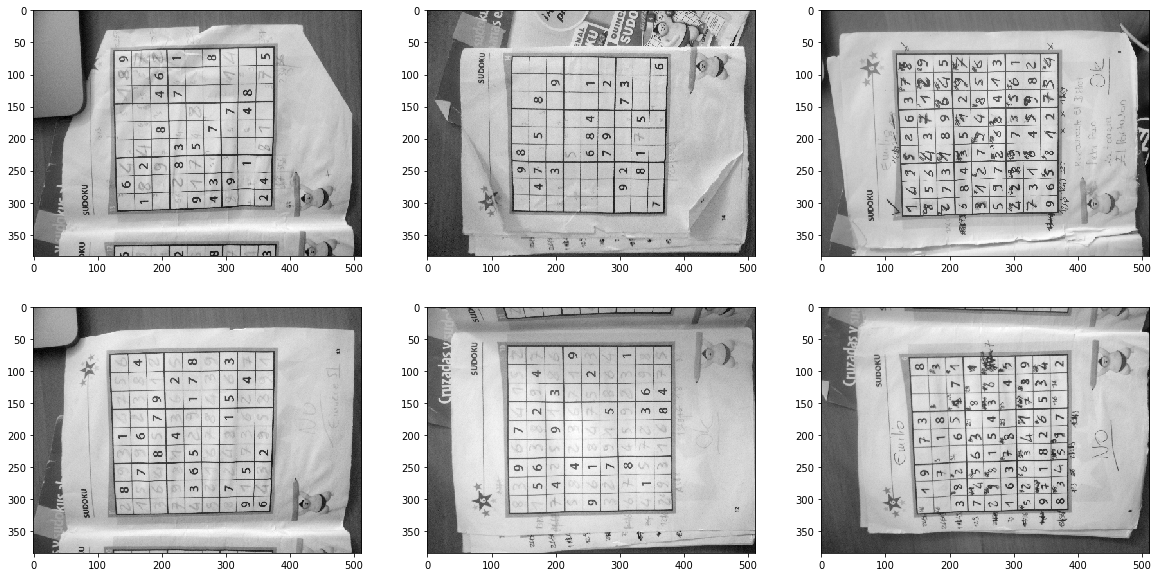

In [3]:
def load_images():
    images_dir = './images/'
    for fname in os.listdir(images_dir):
        img = cv2.imread(images_dir + fname)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, None, fx=0.1, fy=0.1)
        rows, cols = img.shape
        if rows > cols:
            img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
        yield img

images = list(load_images())
show_images(images)

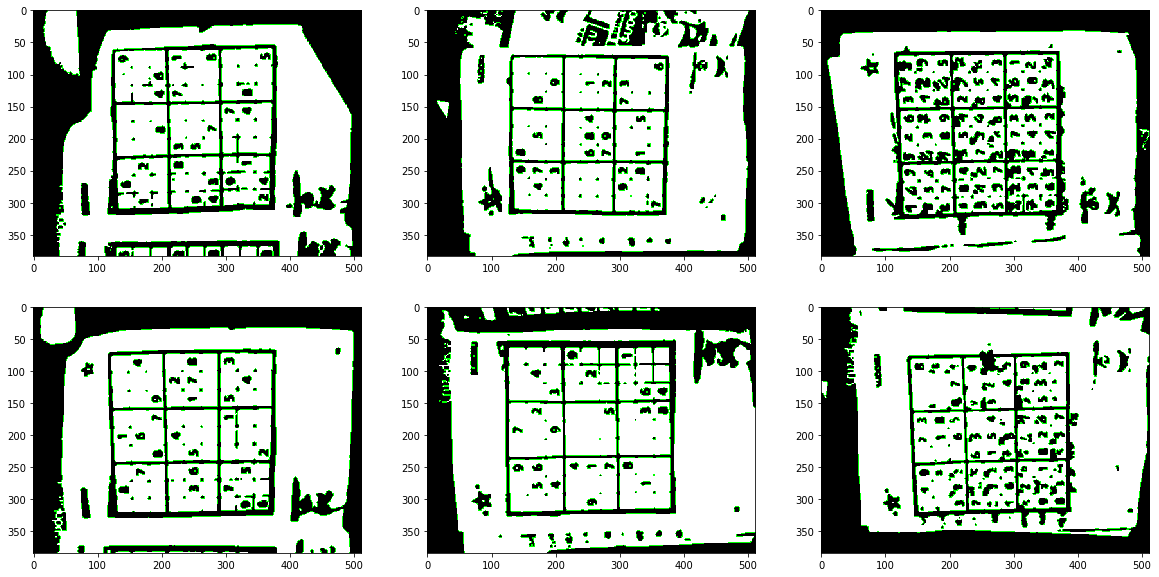

In [4]:
def detect_edges(img):
    blur = cv2.GaussianBlur(img, (5, 5), 0)
    _, threshold = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    blurred = cv2.erode(threshold, None)
    edges = cv2.Canny(blurred, 50, 100, apertureSize=3)
    
    return {
        'img': img,
        'edges': edges,
        'bin': blurred
    }


def edges_plotter(arg):
    new_img = np.zeros(arg['img'].shape + (3,), dtype=np.uint8)
    new_img[:, :, 0] = new_img[:, :, 2] = np.where(arg['edges'], 0, arg['bin'])
    new_img[:, :, 1] = np.where(arg['edges'], 255, arg['bin'])
    plt.imshow(new_img)


images_edges = list(map(detect_edges, images))
show_images(images_edges, edges_plotter)

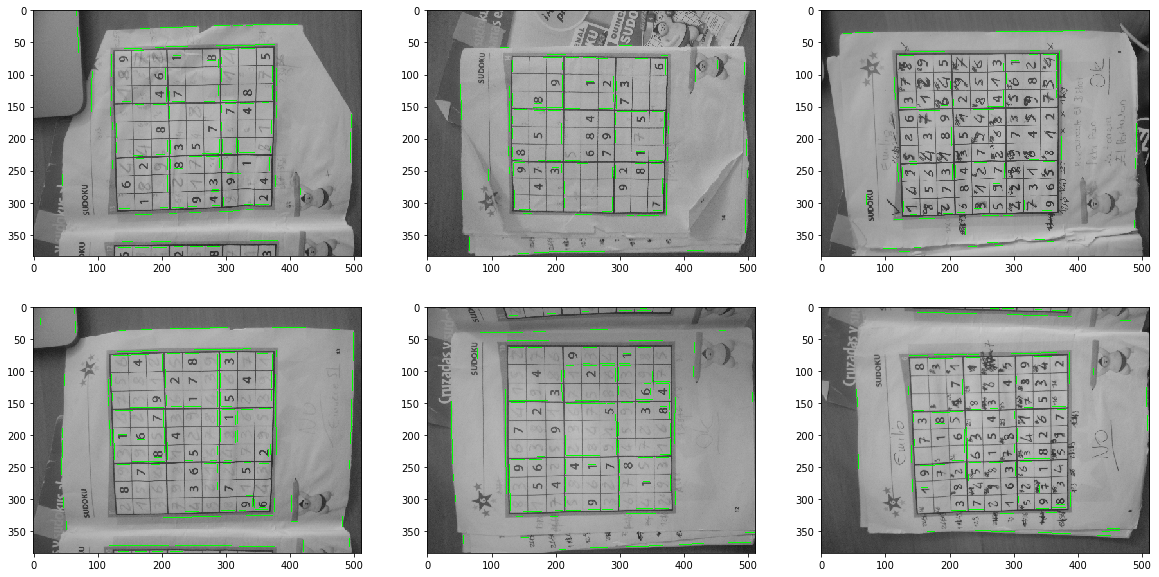

In [5]:
def detect_lines(arg):
    minLineLength = 100
    maxLineGap = 10
    arg['lines'] = np.squeeze(
        cv2.HoughLinesP(arg['edges'], 1, np.pi / 2, 10, minLineLength, maxLineGap)
    )
    return arg


def lines_plotter(arg):
    new_img = np.zeros(arg['img'].shape + (3,), dtype=np.uint8)
    new_img[:, :, 0] = new_img[:, :, 1] = new_img[:, :, 2] = arg['img']
    for x1, y1, x2, y2 in arg['lines']:
        cv2.line(new_img, (x1, y1), (x2, y2), (0, 255, 0), 1)
    return plt.imshow(new_img, cmap='gray')


images_lines = list(map(detect_lines, images_edges))
show_images(images_lines, lines_plotter)

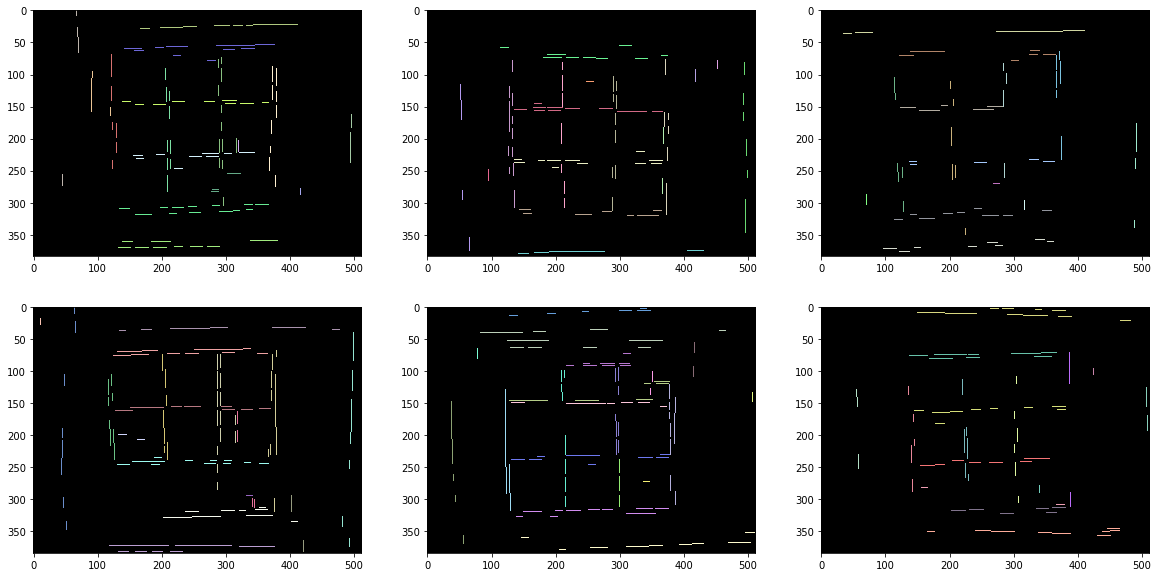

In [6]:
def find_clusters(lines, key):
    lines = sorted(lines, key=key)
    clusters = []
    threshold = 30
    last = [lines[0]]
    for i in range(1, len(lines)):
        if key(lines[i]) - key(last[0]) < threshold:
            last.append(lines[i])
        else:
            clusters.append(last)
            last = [lines[i]]
    
    if last:
        clusters.append(last)

    return clusters


def cluster_lines(arg):
    tol = 3 * np.pi / 180
    
    vertical, horizontal = [], []
    for x1, y1, x2, y2 in arg['lines']:
        angle = np.arctan(abs((y2 - y1) / (x2 - x1))) if x1 != x2 else np.pi
        
        if angle > np.pi / 2 - tol or angle < - np.pi + tol:
            dest = vertical
        elif -tol < angle < tol:
            dest = horizontal
        else:
            continue
        
        dest.append((x1, y1, x2, y2))

    arg['vertical_clusters'] = find_clusters(vertical, key=lambda pc: (pc[0] + pc[2]) / 2)
    arg['horizontal_clusters'] = find_clusters(horizontal, key=lambda pc: (pc[1] + pc[3]) / 2)

    return arg


def plot_clusters(arg):
    new_img = np.zeros(arg['img'].shape + (3,), dtype=np.uint8)
    #new_img[:, :, 0] = new_img[:, :, 1] = new_img[:, :, 2] = arg['img']
    height, width, _ = new_img.shape
    
    for cluster in arg['horizontal_clusters'] + arg['vertical_clusters']:
        color = [
            np.random.randint(100, 256),
            np.random.randint(100, 256),
            np.random.randint(100, 256),
        ]
        #color = (0, 255, 0)
        for x1, y1, x2, y2 in cluster:
            cv2.line(new_img, (x1, y1), (x2, y2), color, 1)

    plt.imshow(new_img)
        

images_clusters = list(map(cluster_lines, images_lines))
show_images(images_clusters, plot_clusters)

Given a cluster of line segments, we find the grid line by linear regression on their endpoint. We increase the stability by inverting x and y coordinates for vertical lines, i.e. we find $w_1$ and $w_2$ such that $y=w_1x_1+w_2$ for horizontal lines and $x=w_1y_1+w_2$ for vertical ones.

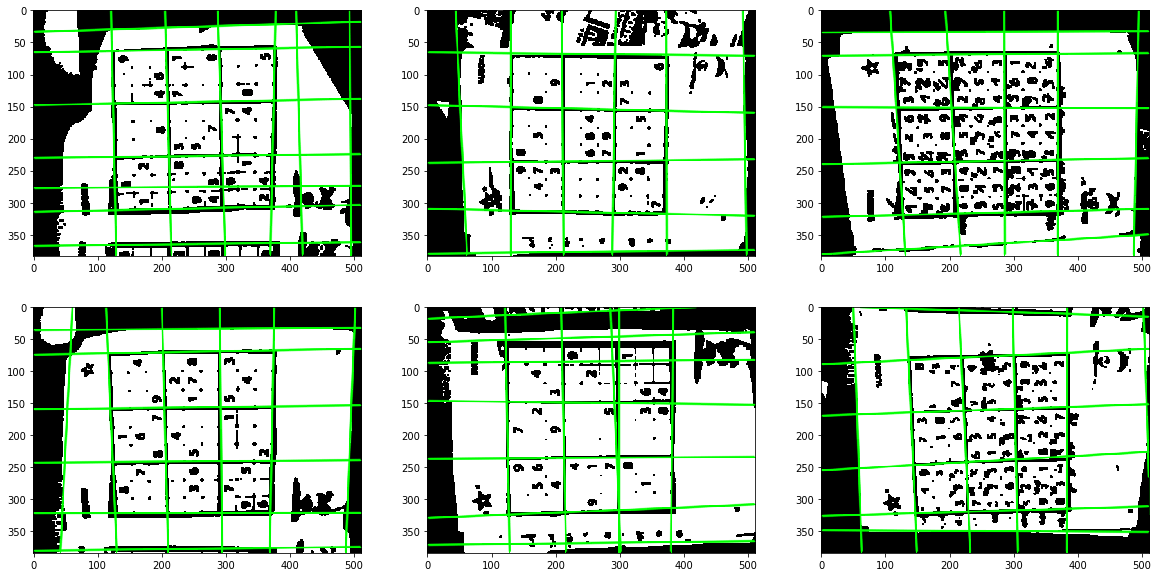

In [7]:
def find_grid_line(cluster, swap_coords, min_count=3, max_deviation=5 * np.pi / 180):
    if len(cluster) < min_count:
        return None
    
    points, targets = [], []
    for x1, y1, x2, y2 in cluster:
        if swap_coords:
            x1, y1, x2, y2 = y1, x1, y2, x2
        points.extend([(x1, 1), (x2, 1)])
        targets.extend([y1, y2])

    X = np.array(points)
    w1, w2 = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(targets)
    return (w1, w2) if abs(w1) < max_deviation else None


def detect_grid_lines(arg):
    arg['horizontal_lines'] = list(filter(None, (
        find_grid_line(cluster, swap_coords=False)
        for cluster in arg['horizontal_clusters']
    )))

    arg['vertical_lines'] = list(filter(None, (
        find_grid_line(cluster, swap_coords=True)
        for cluster in arg['vertical_clusters']
    )))
    
    return arg


def plot_grid_lines(arg):
    new_img = np.zeros(arg['bin'].shape + (3,), dtype=np.uint8)
    new_img[:, :, 0] = new_img[:, :, 1] = new_img[:, :, 2] = arg['bin']
    height, width, _ = new_img.shape
    
    h_lines = [(  # formula: y = w1 * x + w2
        0, int(w2), width, int(w1 * width + w2)
    ) for w1, w2 in arg['horizontal_lines'] if abs(w1) < 5 * np.pi / 180]
    
    v_lines = [(  # formula: x = w1 * y + w2
        int(w2), 0, int(w1 * height + w2), height
    ) for w1, w2 in arg['vertical_lines'] if abs(w1) < 5 * np.pi / 180]
    
    for x1, y1, x2, y2 in h_lines + v_lines:
        cv2.line(new_img, (x1, y1), (x2, y2), (0, 255, 0), 2, cv2.LINE_AA)
    
    return plt.imshow(new_img, cmap='gray')  


images_grid_lines = list(map(detect_grid_lines, images_clusters))
show_images(images_grid_lines, plot_grid_lines)

/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in double_scalars


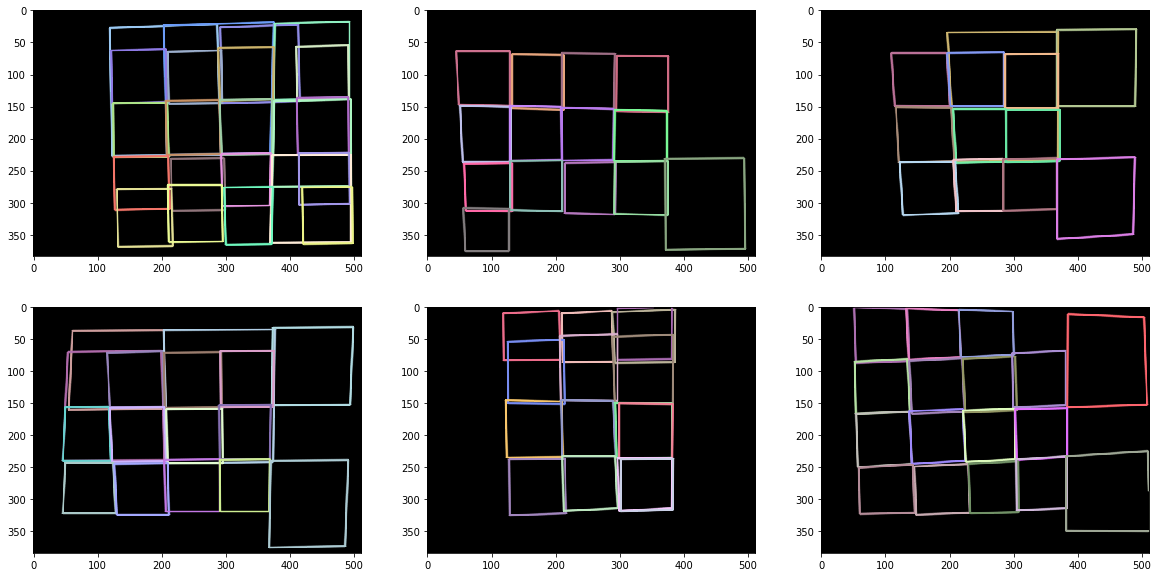

In [8]:
def intersect(v1, v2, h1, h2):
    x = (v2 * h1 + h2) / (1 - h1 * v1)
    y = (v1 * h2 + v2) / (1 - h1 * v1)
    return x, y


def compute_rectangle(h1, h2, v1, v2):
    (h1_w1, h1_w2), (h2_w1, h2_w2) = h1, h2
    (v1_w1, v1_w2), (v2_w1, v2_w2) = v1, v2

    # intersections called a, b, c, d, clockwise from top left
    ax, ay = intersect(h1_w1, h1_w2, v1_w1, v1_w2)
    bx, by = intersect(h1_w1, h1_w2, v2_w1, v2_w2)
    cx, cy = intersect(h2_w1, h2_w2, v2_w1, v2_w2)
    dx, dy = intersect(h2_w1, h2_w2, v1_w1, v1_w2)

    l_ab = np.sqrt((ax - bx)**2 + (ay - by)**2)
    l_bc = np.sqrt((bx - cx)**2 + (by - cy)**2)
    l_cd = np.sqrt((cx - dx)**2 + (cy - dy)**2)
    l_da = np.sqrt((dx - ax)**2 + (dy - ay)**2)

    left, right = (ax + dx) / 2, (bx + cx) / 2
    top, bottom = (ay + by) / 2, (cy + dy) / 2
    
    return right - left, bottom - top, [
        (ax, ay), (bx, by), (cx, cy), (dx, dy)
    ]


def find_squares(arg):
    height, width = arg['img'].shape
    
    min_width, max_width = width / 9, width / 3
    min_height, max_height = height / 9, height / 3
    
    horizontal = sorted(arg['horizontal_lines'], key=lambda w: w[1])
    vertical = sorted(arg['vertical_lines'], key=lambda w: w[1])
    
    squares = []
    for i1 in range(len(horizontal) - 1):
        for j1 in range(len(vertical) - 1):
            i2, j2 = i1, j1
            
            width = height = 0
            found = False
            while not found and width < max_width and height < max_height and i2 < len(horizontal) and j2 < len(vertical):
                width, height, vertices = compute_rectangle(
                    horizontal[i1], horizontal[i2],
                    vertical[j1], vertical[j2]
                )
                
                aspect_ratio = width / height
                if width > min_width and height > min_height and 0.8 < aspect_ratio < 1.2:
                    squares.append(vertices)
                    found = True
                elif aspect_ratio < 1:
                    j2 += 1
                else:
                    i2 += 1
    
    arg['squares'] = squares
    return arg


def plot_squares(arg):
    new_img = np.zeros(arg['img'].shape + (3,), dtype=np.uint8)
    #new_img[:, :, 0] = new_img[:, :, 1] = new_img[:, :, 2] = arg['bin']
    height, width, _ = new_img.shape
    
    h_lines = [(  # formula: y = w1 * x + w2
        0, int(w2), width, int(w1 * width + w2)
    ) for w1, w2 in arg['horizontal_lines'] if abs(w1) < 5 * np.pi / 180]
    
    v_lines = [(  # formula: x = w1 * y + w2
        int(w2), 0, int(w1 * height + w2), height
    ) for w1, w2 in arg['vertical_lines'] if abs(w1) < 5 * np.pi / 180]
    
    #for x1, y1, x2, y2 in h_lines + v_lines:
    #    cv2.line(new_img, (x1, y1), (x2, y2), (0, 255, 0), 2, cv2.LINE_AA)
    
    for vertices in arg['squares']:
        color = [
            np.random.randint(100, 256),
            np.random.randint(100, 256),
            np.random.randint(100, 256),
        ]
        #color = [255, 0, 0]
        vs = np.array([vertices])
        vs += 6 * np.random.random() - 3
        cv2.polylines(new_img, vs.astype(np.int32), True, color, 2, cv2.LINE_AA)
        
    plt.imshow(new_img)


images_squares = list(map(find_squares, images_grid_lines))
show_images(images_squares, plot_squares)